# Calibrating and Undistorting

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
%matplotlib inline

In [3]:
# preparing object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
#print (objp)

In [4]:
# Arrays to store all object points and image points from all the images
objpoints = []
imgpoints = []

True


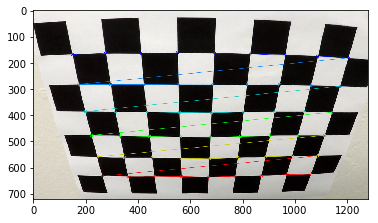

In [5]:
# Testing the detection of chessboard points on one image first
image = mpimg.imread('./camera_cal/calibration2.jpg')
#plt.imshow(image)

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#plt.imshow(gray, cmap = 'gray')

#Finding Chessboard Corners
### Comment : for calibration1.jpg, we need to use corners as (9,5), if not ret returns False. For all other images (9,6) works
ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
print (ret)
if ret == True:
    cv2.drawChessboardCorners(image, (9,6), corners, ret)
    plt.imshow(image)

In [6]:
# Making a list of images
images = glob.glob('./camera_cal/calibration*.jpg')

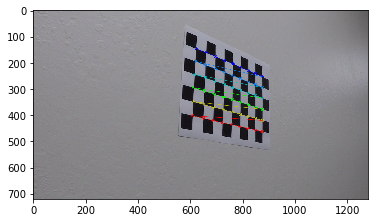

In [7]:
for idx,fname in enumerate(images):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
    #Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)

In [8]:
# Calibrating Camera 
image_size = (image.shape[0], image.shape[1])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
print (dist)
print (mtx)

[[ -2.41018767e-01  -5.30665431e-02  -1.15811319e-03  -1.28284935e-04
    2.67026162e-02]]
[[  1.15396100e+03   0.00000000e+00   6.69706492e+02]
 [  0.00000000e+00   1.14802503e+03   3.85655582e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [9]:
# Undistorting 
image = mpimg.imread('./camera_cal/calibration1.jpg')
dst = cv2.undistort(image, mtx,dist,None, mtx)

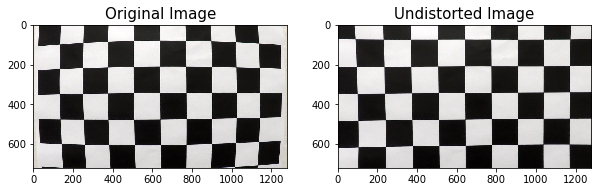

In [10]:
# Plotting
f, (ax1,ax2) = plt.subplots(1,2, figsize = (10,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize = 15)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize = 15)

# Binary Thresholding

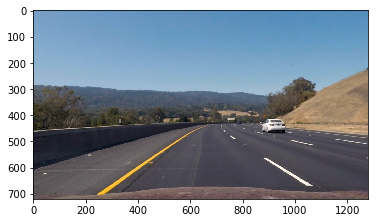

In [362]:
## Reading image & Undistorting it right away
image = mpimg.imread('./test_images/test3.jpg')
#image = mpimg.imread('./signs_vehicles_xygrad.png')
### Comment : Undistorting the image right away
image = cv2.undistort(image, mtx,dist,None, mtx)
plt.imshow(image)

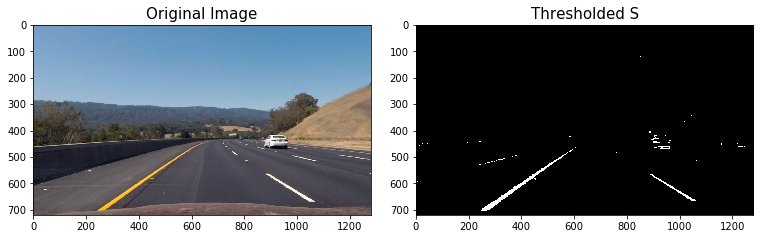

In [363]:
def hls_s(image, thresh = (0,255)):
    hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    ### Comment : Using s channel to detect lanes
    s_channel = hls[:,:,2]
    binary = np.zeros_like(s_channel)
    binary[(s_channel>thresh[0]) & (s_channel <=thresh[1])] = 1
    binary_output = np.copy(binary)
    return binary_output

s_image = hls_s(image, thresh = (120,255))
#plt.imshow(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(s_image, cmap='gray')
ax2.set_title('Thresholded S', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


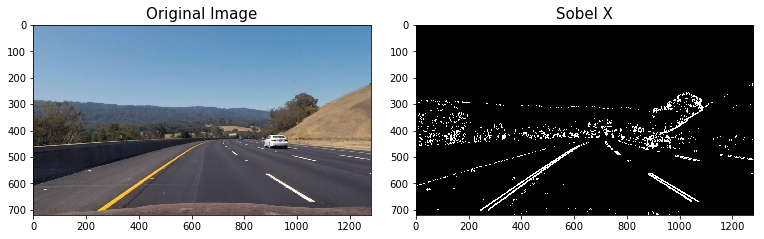

In [364]:
#Applying Sobel
def sobel_x(image, thresh, kernel_size):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize = kernel_size)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    thresh_min, thresh_max  = thresh[0], thresh[1]
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sx_binary

sobel = sobel_x(image, (20,200), 9)  

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(sobel, cmap='gray')
ax2.set_title('Sobel X', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


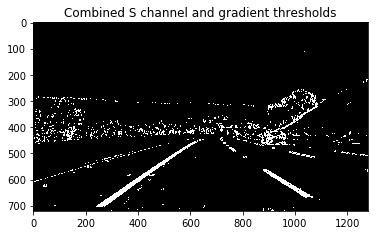

In [365]:
color_binary = np.dstack(( np.zeros_like(sobel), sobel, s_image))

# Combine the two binary thresholds
combined_binary = np.zeros_like(sobel)
combined_binary[(sobel == 1) | (s_image == 1)] = 1

plt.title('Combined S channel and gradient thresholds')
plt.imshow(combined_binary, cmap='gray')

# Warped Image

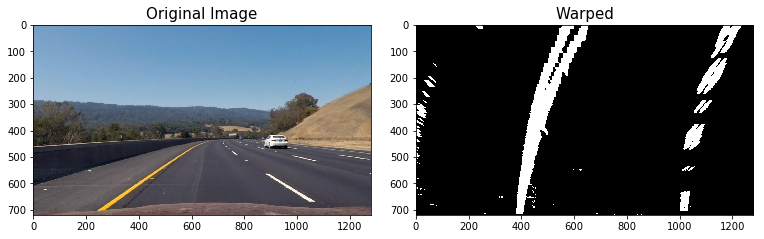

In [366]:
import matplotlib.patches as patches

#image = mpimg.imread('./test_images/straight_lines2.jpg')
#plt.imshow(image)

src = np.float32([[690, 450],[1100, 720],[200, 720],[600, 450]])
dst = np.float32([[985, 0],[985, 720],[370, 720],[370, 0]])

def warp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    warped = cv2.warpPerspective(img,M, img_size, flags =  cv2.INTER_LINEAR)
    
    return warped

warp_im = warp(combined_binary,src,dst)

source_line = plt.Polygon(src, fill=None, edgecolor='r')
dst_line = plt.Polygon(dst, fill=None, edgecolor='r')


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
f.tight_layout()
#ax1.add_patch(source_line)
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=15)
#ax2.add_patch(dst_line)
ax2.imshow(warp_im, cmap = 'gray')
ax2.set_title('Warped', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

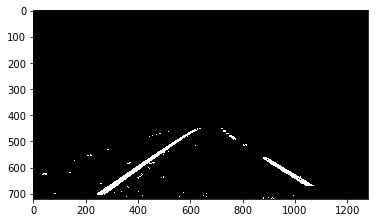

In [367]:
Minv = cv2.getPerspectiveTransform(dst,src)
warp_inv = cv2.warpPerspective(warp_im, Minv, (1280,720),flags =  cv2.INTER_LINEAR)
plt.imshow(warp_inv, cmap = 'gray')

(720, 1280)


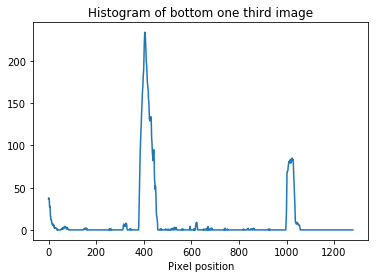

In [368]:
img = warp_im
print ((img.shape))
# sum of pixels in the bottom 1/3rd of image 
histogram = np.sum(img[int(img.shape[0]/1.5):,:], axis=0)
plt.plot(histogram)
plt.title ("Histogram of bottom one third image")
plt.xlabel("Pixel position")

(720, 0)

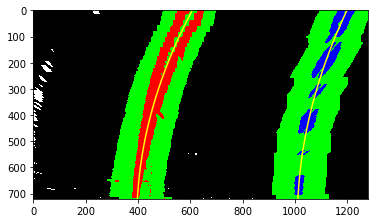

In [369]:
binary_warped = warp_im
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 360
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

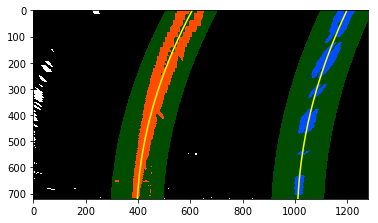

In [370]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
'''image = mpimg.imread('./test_images/test2.jpg')
#image = mpimg.imread('./signs_vehicles_xygrad.png')
image = cv2.undistort(image, mtx,dist,None, mtx)
sobel = sobel_x(image, (20,200), 9)
s_image = hls_s(image, thresh = (150,255))
combined_binary = np.zeros_like(sobel)
combined_binary[(sobel == 1) | (s_image == 1)] = 1
warp_im = warp(combined_binary,src,dst)
binary_warped = warp_im'''

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
#And you're done! But let's visualize the result here as well
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)



In [371]:
print (right_fitx[0])
print (right_fitx[-1])

1198.62658913
1011.71377429


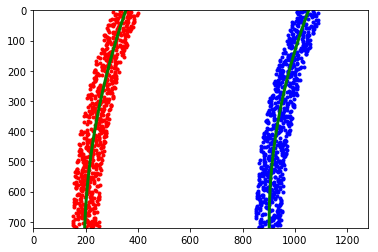

In [372]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [373]:
print (right_fitx[0])
print (right_fitx[-1])

1052.43642781
901.88778338


In [374]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

2015.13514919 1612.64231092


In [375]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

660.333942305 m 529.53334281 m


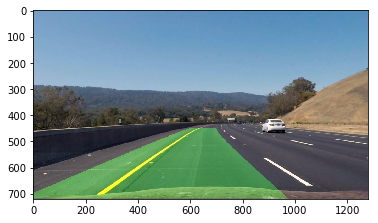

In [376]:
# Create an image to draw the lines on
warped = warp_im
Minv = cv2.getPerspectiveTransform(dst,src)
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]),flags =  cv2.INTER_LINEAR) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(result)